In [1]:
import numpy
import os
import cPickle as pickle
import os.path
import matplotlib.pyplot as plt
import time
import json
import MeCab
import re
import codecs

import sys
sys.path.append("../../MyPythonModule")
import mymodule
from LDA_kai import LDA

In [2]:
def status_writer(dst_dir,opt,comment=None):
    status_file_path = os.path.join(dst_dir,"status.txt")
    with open(status_file_path,"w") as fo:
        for k,v in opt.items():
            print >> fo,k,"=",v
        print >> fo,""
        if comment != None:
            print >> fo,"comment"
            print >> fo,comment

In [3]:
def suffix_generator(target=None,is_largest=False):
    suffix = ""
    if target != None:
        suffix += "_" + target
    if is_largest == True:
        suffix += "_largest"
    return suffix

In [4]:
def perp_graph(perp_path,opt="perp"):
    dir = os.path.dirname(perp_path)
    f = open(perp_path)
    perplist = []
    for line in f:
        elm = line.split(",")
        elm[1].rstrip()#改行記号除去
        elm = float(elm[1])
        perplist.append(elm)
    plt.plot(perplist)
    plt.savefig(os.path.join(dir,opt+".png"))
    plt.clf()#現在描画したグラフを消す(消さないと次回の描画時に残る)

In [5]:
def output_summary(exp_dir,lda):
    with open(os.path.join(exp_dir,"summary.txt"),"w") as fout:
        phi = lda.phi()
        for k in xrange(lda.K):
            print "\nTopic %d" % (k)
            print >> fout, "\nTopic %d" % (k+1)
            for w in numpy.argsort(-phi[k])[:20]:
                try:
                    print >> fout, "%s\t%f" % (lda.vocas[w], phi[k,w])
                    print "%s: %f" % (lda.vocas[w], phi[k,w])
                except:
                    print "cdecs_error"

In [6]:
search_word = u"Test"
max_page = 10
root_dir = "../Data/Search_" + search_word + "_" + unicode(max_page) + "_add_childs" 
is_largest = True
target = "myexttext"
G_name = "G" + suffix_generator(target=target,is_largest=is_largest)
use_to_link = "to_ext_links"
K = 10
iteration = 500
alpha = 0.001
beta = 0.001
no_below = 5#単語の最低出現文書数
no_above = 0.2#単語の最大出現文書比率
no_less = 20#文書に含まれる最低単語数
do_hparam_update = False#パラメータを更新するか否か
chasen_dir_name = "Chasen" + suffix_generator(target,is_largest)
exp_name = "K" + unicode(K) + suffix_generator(target,is_largest)
comment = None

In [7]:
chasen_dir = os.path.join(root_dir,chasen_dir_name)
if exp_name == None:
    exp_name = "K" + unicode(K) + "_freqcut3" #+"_"+unicode(try_no)
exp_dir = os.path.join(root_dir,exp_name)
if not os.path.exists(exp_dir):
    os.mkdir(exp_dir)

In [8]:
files = os.listdir(chasen_dir)
files = [file for file in files if os.path.splitext(file)[1] == ".txt"]
mymodule.sort_nicely(files)
files

[u'0.txt',
 u'2.txt',
 u'3.txt',
 u'4.txt',
 u'5.txt',
 u'6.txt',
 u'7.txt',
 u'9.txt',
 u'10.txt',
 u'11.txt',
 u'12.txt',
 u'13.txt',
 u'14.txt',
 u'15.txt',
 u'16.txt',
 u'17.txt',
 u'18.txt',
 u'19.txt',
 u'20.txt',
 u'21.txt',
 u'22.txt',
 u'23.txt',
 u'24.txt',
 u'25.txt',
 u'26.txt',
 u'27.txt',
 u'28.txt',
 u'29.txt',
 u'30.txt',
 u'31.txt',
 u'32.txt',
 u'33.txt',
 u'34.txt',
 u'35.txt',
 u'36.txt',
 u'37.txt',
 u'38.txt',
 u'39.txt',
 u'40.txt',
 u'41.txt',
 u'42.txt',
 u'43.txt',
 u'44.txt',
 u'45.txt',
 u'46.txt',
 u'47.txt',
 u'48.txt',
 u'49.txt',
 u'50.txt',
 u'51.txt',
 u'52.txt',
 u'53.txt',
 u'56.txt']

In [9]:
len(files)

53

In [10]:
with open(os.path.join(root_dir,"file_id_dict.dict"),"r") as fi:
    file_id_dict = pickle.load(fi)

In [11]:
corpus = []
for i,file in enumerate(files):
    with open(os.path.join(chasen_dir,file),"r") as fi:
        doc = [word.rstrip() for word in fi.readlines()]
        corpus.append(doc)
len(corpus)

53

In [12]:
corpus

[['\xe3\x83\xad\xe3\x82\xb0\xe3\x82\xa4\xe3\x83\xb3',
  '\xe3\x83\x9d\xe3\x82\xa4\xe3\x83\xb3\xe3\x83\x88',
  '\xe6\x9c\x9f\xe9\x99\x90',
  'iPhone',
  'iPhone',
  'PlusiPhone',
  'iPhone',
  'Plus',
  'with',
  'AppleCare',
  'Services',
  '\xe3\x83\xa1\xe3\x83\x83\xe3\x82\xbb\xe3\x83\xbc\xe3\x82\xb8',
  '\xe3\x83\x97\xe3\x83\xa9\xe3\x82\xb9',
  '\xe3\x83\xa1\xe3\x83\x83\xe3\x82\xbb\xe3\x83\xbc\xe3\x82\xb8',
  '\xe5\x88\x9d\xe6\x9c\x9f',
  '\xe3\x83\x86\xe3\x82\xb6\xe3\x83\xaa\xe3\x83\xb3\xe3\x82\xb0',
  'iPhone',
  '\xe3\x83\xa2\xe3\x83\x90\xe3\x82\xa4\xe3\x83\xab\xe3\x83\xab\xe3\x83\xbc\xe3\x82\xbf\xe3\x83\xbc',
  '\xe4\xbb\xa3\xe3\x82\x8f\xe3\x82\x8a',
  'LTE',
  'NET',
  'for',
  'DATA',
  'iPhone',
  'au',
  'iPhone',
  '\xe3\x82\xa2\xe3\x82\xaf\xe3\x82\xbb\xe3\x82\xb5\xe3\x83\xaa\xe3\x83\xbc',
  'iPad',
  '\xe3\x82\xb3\xe3\x83\xb3\xe3\x83\x94\xe3\x83\xa5\xe3\x83\xbc\xe3\x82\xbf',
  '\xe3\x82\xb3\xe3\x83\xb3\xe3\x83\x94\xe3\x83\xa5\xe3\x83\xbc\xe3\x82\xbf',
  'Apple',
  'Pay',
  

In [13]:
smartinit = True
lda = LDA(K, alpha, beta)
lda.set_corpus(corpus,no_below=no_below,no_above=no_above,no_less=no_less,smartinit=smartinit,file_id_dict=file_id_dict)

made words 2018-12-13 14:14:33.840453
made corpus 2018-12-13 14:14:34.255734


In [14]:
M = len(lda.docs)
M

43

In [15]:
V = len(lda.vocas)
V

157

In [16]:
lda.vocas

['\xe3\x83\xad\xe3\x82\xb0\xe3\x82\xa4\xe3\x83\xb3',
 '\xe3\x83\x9d\xe3\x82\xa4\xe3\x83\xb3\xe3\x83\x88',
 'iPhone',
 'Plus',
 'with',
 'AppleCare',
 '\xe3\x83\xa1\xe3\x83\x83\xe3\x82\xbb\xe3\x83\xbc\xe3\x82\xb8',
 'au',
 'iPad',
 '\xe3\x82\xb3\xe3\x83\xb3\xe3\x83\x94\xe3\x83\xa5\xe3\x83\xbc\xe3\x82\xbf',
 'Apple',
 'Pay',
 '\xe3\x82\xab\xe3\x83\xbc\xe3\x83\x89',
 '\xe6\x83\x85\xe5\xa0\xb1',
 '\xe6\xb3\x95\xe4\xba\xba',
 '\xe3\x81\x8a\xe5\xae\xa2',
 '\xe5\x86\x85\xe5\xae\xb9',
 'ID',
 '\xe3\x83\x9c\xe3\x82\xbf\xe3\x83\xb3',
 '\xe7\x94\xbb\xe9\x9d\xa2',
 '\xe6\xa9\x9f\xe7\xa8\xae',
 '\xe3\x82\xaf\xe3\x83\xac\xe3\x82\xb8\xe3\x83\x83\xe3\x83\x88\xe3\x82\xab\xe3\x83\xbc\xe3\x83\x89',
 '\xe3\x82\xb9\xe3\x83\x9e\xe3\x83\xbc\xe3\x83\x88',
 '\xe3\x83\x95\xe3\x82\xa9\xe3\x83\xb3',
 '\xe3\x82\xa4\xe3\x83\xb3\xe3\x82\xbf\xe3\x83\xbc\xe3\x83\x8d\xe3\x83\x83\xe3\x83\x88',
 'XR',
 '\xe6\x97\xa5\xe6\x9c\xac',
 '\xe3\x83\x87\xe3\x82\xa3\xe3\x82\xb9\xe3\x83\x97\xe3\x83\xac\xe3\x82\xa4',
 '\xe6\xa5\xad\

In [17]:
doclen_ave = sum([len(_doc) for _doc in lda.docs]) / float(len(lda.docs))
doclen_ave

136.90697674418604

In [18]:
fp = open(os.path.join(exp_dir,"_perp.txt"),"w")
ft = open(os.path.join(exp_dir,"_time.txt"), 'w')
start_time = time.time()

In [19]:
for i in range(iteration):
    #sys.stderr.write("-- %d : %.4f\n" % (i, natm.perplexity()))
    lda.inference()
    perp = lda.perplexity()
    print >> fp,("%d,%f" % (i, perp))
    if i != 0 and i%5 == 0:
        lda.hparam_update(do_alpha=do_hparam_update,do_beta=do_hparam_update)
    if i%100 == 0:
        with open(os.path.join(exp_dir,"instance.pkl"), 'w') as fs:
            pickle.dump(lda,fs)
    sys.stderr.write("-- %d" % (i))
elapsed_time = time.time() - start_time
fp.close()

-- 0-- 1-- 2-- 3-- 4-- 5-- 6-- 7-- 8-- 9-- 10-- 11-- 12-- 13-- 14-- 15-- 16-- 17-- 18-- 19-- 20-- 21-- 22-- 23-- 24-- 25-- 26-- 27-- 28-- 29-- 30-- 31-- 32-- 33-- 34-- 35-- 36-- 37-- 38-- 39-- 40-- 41-- 42-- 43-- 44-- 45-- 46-- 47-- 48-- 49-- 50-- 51-- 52-- 53-- 54-- 55-- 56-- 57-- 58-- 59-- 60-- 61-- 62-- 63-- 64-- 65-- 66-- 67-- 68-- 69-- 70-- 71-- 72-- 73-- 74-- 75-- 76-- 77-- 78-- 79-- 80-- 81-- 82-- 83-- 84-- 85-- 86-- 87-- 88-- 89-- 90-- 91-- 92-- 93-- 94-- 95-- 96-- 97-- 98-- 99-- 100-- 101-- 102-- 103-- 104-- 105-- 106-- 107-- 108-- 109-- 110-- 111-- 112-- 113-- 114-- 115-- 116-- 117-- 118-- 119-- 120-- 121-- 122-- 123-- 124-- 125-- 126-- 127-- 128-- 129-- 130-- 131-- 132-- 133-- 134-- 135-- 136-- 137-- 138-- 139-- 140-- 141-- 142-- 143-- 144-- 145-- 146-- 147-- 148-- 149-- 150-- 151-- 152-- 153-- 154-- 155-- 156-- 157-- 158-- 159-- 160-- 161-- 162-- 163-- 164-- 165-- 166-- 167-- 168-- 169-- 170-- 171-- 172-- 173-- 174-- 175-- 176-- 177-- 178-- 179-- 180-- 181-- 182-- 183-- 184

In [20]:
len(lda.docs)

43

In [21]:
len(lda.theta())

43

In [22]:
with open(os.path.join(exp_dir,"instance.pkl"), 'w') as fs:
    pickle.dump(lda,fs)

In [23]:
print >> ft,"alpha=", lda.alpha
print >> ft,"beta=" ,lda.beta
print >> ft,"time=" ,elapsed_time

print >> ft,"len(lda.docs)=" ,str(len(lda.docs)) + "(Mと同一)"
print >> ft,"len(lda.vocas)=" ,str(len(lda.vocas)) + "(Vと同一)"
print >> ft,"len(lda.theta())=" ,str(len(lda.theta())) + "(Mと同一)"
ft.close()

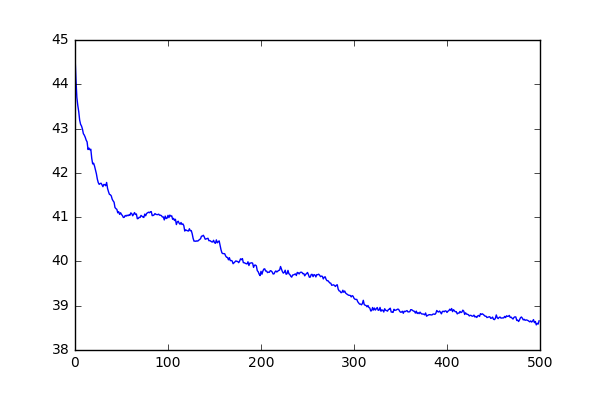

In [24]:
perp_graph(os.path.join(exp_dir,"_perp.txt"),"perp")
from IPython.display import Image, display_png
display_png(Image(os.path.join(exp_dir,"perp.png")))

In [25]:
output_summary(exp_dir,lda)


Topic 0
ユーザ: 0.265308
製品: 0.265308
レベル: 0.164243
使い方: 0.075811
世界: 0.075811
アプリケーション: 0.063178
モバイル: 0.037912
ページ: 0.037912
ハードウェア: 0.012646
容量: 0.000013
送料: 0.000013
データ: 0.000013
無料: 0.000013
届け: 0.000013
オンライン: 0.000013
場所: 0.000013
魅力: 0.000013
画像: 0.000013
地域: 0.000013
国: 0.000013

Topic 1
写真: 0.156474
方法: 0.111768
フォン: 0.067062
高速: 0.051096
商標: 0.051096
XR: 0.051096
Inc: 0.044709
背景: 0.041516
業界: 0.031936
センサー: 0.031936
モード: 0.028743
HDR: 0.028743
他: 0.025549
All: 0.022356
rights: 0.022356
reserved: 0.022356
パスワード: 0.022356
ロゴ: 0.022356
作品: 0.022356
画像: 0.019163

Topic 2
Apple: 0.491180
方法: 0.046558
デバイス: 0.040739
App: 0.033755
iPad: 0.032591
Mac: 0.031427
iPhone: 0.029099
規約: 0.027936
支払い: 0.023280
ユーザ: 0.018624
Pay: 0.017460
コンピュータ: 0.016296
iOS: 0.016296
アカウント: 0.015132
会社: 0.013968
メッセージ: 0.013968
番号: 0.010477
モデル: 0.010477
場所: 0.010477
アクセサリ: 0.010477

Topic 3
情報: 0.190131
お客様: 0.103273
サイト: 0.095750
個人: 0.092330
お客: 0.058818
データ: 0.037616
プライバシー: 0.031461
目的: 0.027358
月: 0

In [26]:
status_writer(os.path.join(root_dir,exp_name),{"topic_num":K,"M":M,"V":V,"doclen_ave":doclen_ave,"iteration":iteration,"alpha":alpha,"beta":beta,"no_below":no_below,"no_above":no_above,"no_less":no_less,"is_largest":is_largest,"do_hparam_update":do_hparam_update},comment=comment)